<a href="https://colab.research.google.com/github/gregofoegbu/gregofoegbu/blob/main/Copy_of_MLProject2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls "/content/gdrive/MyDrive/Colab Notebooks"

 Augmenter.ipynb	       data_2		       MLproject.ipynb
'Copy of MLProject2-1.ipynb'   Machinelearning.ipynb   Scraper.ipynb
'Copy of MLproject.ipynb'      MLProject2-1.ipynb
 data			       MLProject2.ipynb


In [3]:
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
from matplotlib import pyplot as plt 
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pathlib
import seaborn as sns


In [5]:
DATASET_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data_2'
data_dir = pathlib.Path(DATASET_PATH)

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

In [7]:
 commands

array(['Pantropical_Spotted_Dolphin', 'Melon_Headed_Whale',
       'Bowhead_Whale', 'Short-Finned_Pilot_Whale'], dtype='<U27')

In [8]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1976
Number of examples per label: 520
Example file tensor: tf.Tensor(b'/content/gdrive/MyDrive/Colab Notebooks/data_2/Melon_Headed_Whale/noise91012007.wav', shape=(), dtype=string)


In [9]:
train_files = filenames[:1580]
val_files = filenames[1580: 1580 + 198]
test_files = filenames[-198:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1580
Validation set size 198
Test set size 198


In [10]:
test_file = tf.io.read_file(DATASET_PATH+'/Bowhead_Whale/7202100Q.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([29040, 1])

In [11]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [12]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [13]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

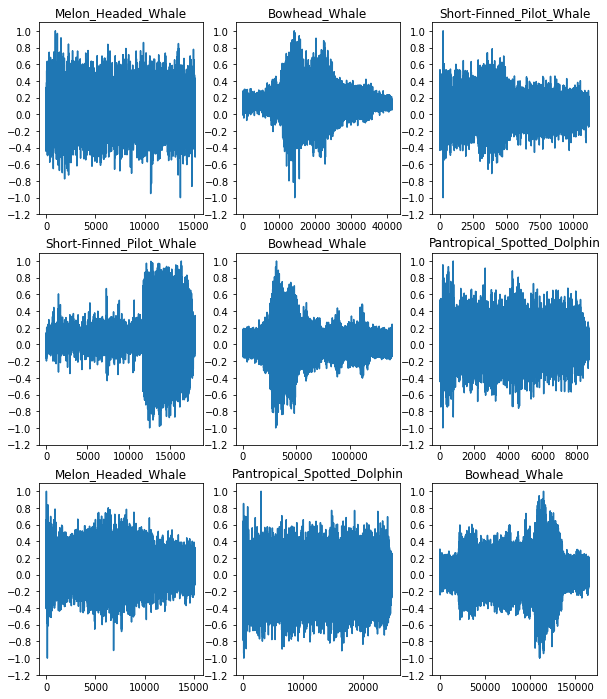

In [15]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [16]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [17]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: Melon_Headed_Whale
Waveform shape: (15125,)
Spectrogram shape: (124, 129, 1)


In [18]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

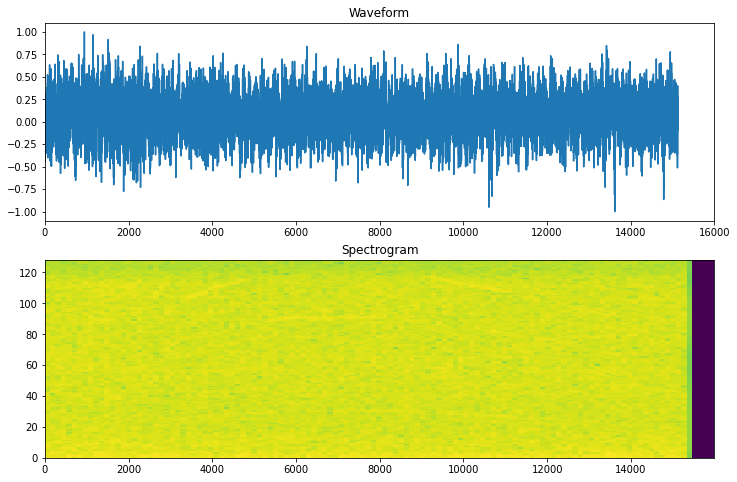

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [20]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [21]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

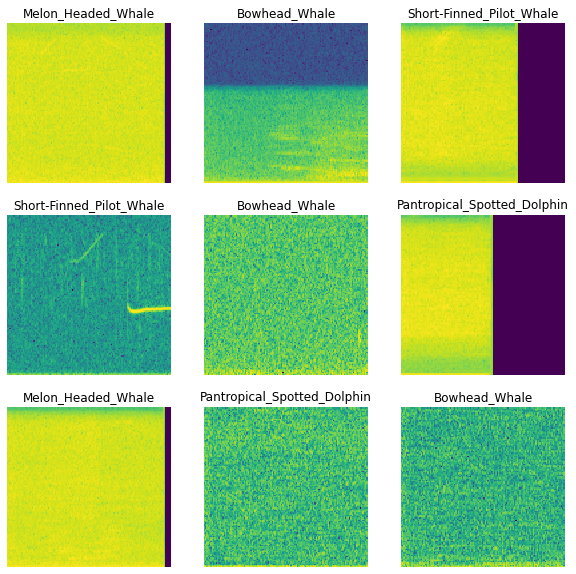

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [23]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [24]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [25]:
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [26]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [27]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Resizing, Normalization
from tensorflow.keras import layers
from tensorflow.keras import models

In [29]:
norm_layer = layers.Normalization()

norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
99/99 [==============================] - 17s 158ms/step - loss: 0.9630 - accuracy: 0.6089 - val_loss: 0.5782 - val_accuracy: 0.7374
Epoch 2/10
99/99 [==============================] - 7s 73ms/step - loss: 0.6446 - accuracy: 0.7468 - val_loss: 0.4206 - val_accuracy: 0.8434
Epoch 3/10
99/99 [==============================] - 7s 75ms/step - loss: 0.4680 - accuracy: 0.8241 - val_loss: 0.3513 - val_accuracy: 0.8586
Epoch 4/10
99/99 [==============================] - 8s 77ms/step - loss: 0.3538 - accuracy: 0.8646 - val_loss: 0.3058 - val_accuracy: 0.8788
Epoch 5/10
99/99 [==============================] - 7s 75ms/step - loss: 0.3031 - accuracy: 0.8905 - val_loss: 0.2858 - val_accuracy: 0.8889
Epoch 6/10
99/99 [==============================] - 14s 141ms/step - loss: 0.2379 - accuracy: 0.9095 - val_loss: 0.2581 - val_accuracy: 0.9040
Epoch 7/10
99/99 [==============================] - 8s 78ms/step - loss: 0.2167 - accuracy: 0.9152 - val_loss: 0.2609 - val_accuracy: 0.9192
Epoch 8/1

In [32]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


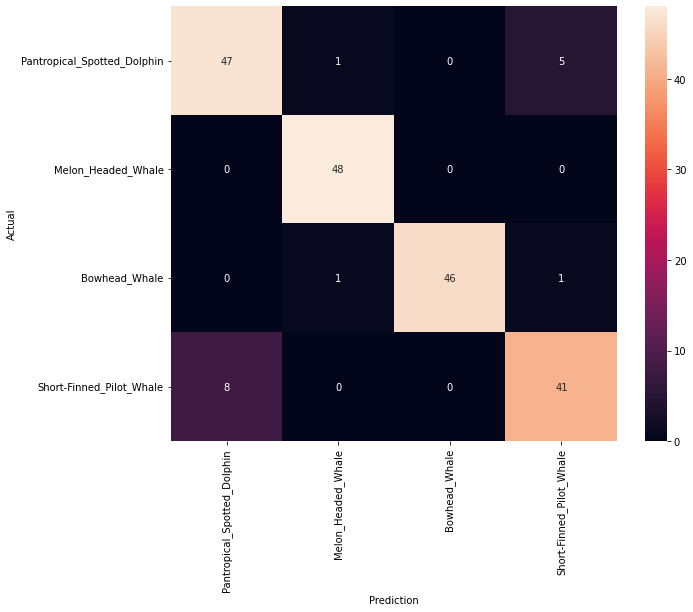

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [34]:
from sklearn import metrics

In [35]:
print(metrics.classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.855     0.887     0.870        53
           1      0.960     1.000     0.980        48
           2      1.000     0.958     0.979        48
           3      0.872     0.837     0.854        49

    accuracy                          0.919       198
   macro avg      0.922     0.920     0.921       198
weighted avg      0.920     0.919     0.919       198

